Testing the quality of the redshift cuts on LSST Y1 and Y10 catalogs, plus Euclid photometry

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

import jax.numpy as jnp
from jax.experimental.optimizers import adam
from pzflow import FlowEnsemble
from pzflow.bijectors import Chain, StandardScaler, RollingSplineCoupling
from pzflow.distributions import Uniform

Load the catalogs and split them into training and test sets

In [2]:
y1_catalog = pd.read_pickle("catalogs/y1_catalog.pkl")
y10_catalog = pd.read_pickle("catalogs/y10_catalog.pkl")

N_train = int(100e3)
N_test = int(20e3)

y1_sample = y1_catalog.sample(n=N_train + N_test, random_state=0)
y1_train, y1_test = y1_sample[:N_train], y1_sample[N_train:] 

y10_sample = y10_catalog.sample(n=N_train + N_test, random_state=0)
y10_train, y10_test = y10_sample[:N_train], y10_sample[N_train:] 

Now let's create the bijector and latent distribution for the normalizing flows.

In [3]:
# I am abusing StandardScaler to make redshifts run (-5, 5)
means = 3.5 / 2
stds = (3.5 / 2) / 5

# construct our bijector
# by chaining all these layers
def get_bijector(n_conditions):
    return Chain(
        StandardScaler(means, stds),
        RollingSplineCoupling(nlayers=1, n_conditions=n_conditions),
    )

latent = Uniform((-5, 5))

Now we create a `FlowEnsemble` for each catalog

In [4]:
N = 10 # number of flows in each ensemble

# dictionary of Y1 ensembles
y1_ensembles = {
    name: FlowEnsemble(["redshift"], get_bijector(len(conditional_columns)), conditional_columns, latent, N)
    for name, conditional_columns in [
        ["LSST Y1 w/ u", list("ugrizy")],
        ["LSST Y1 w/o u", list("grizy")],
        ["LSST Y1 + Euclid w/ u", list("ugrizy")+["ey"]+list("jh")],
        ["LSST Y1 + Euclid w/o u", list("grizy")+["ey"]+list("jh")],
    ]
}

# dictionary of Y10 ensembles
y10_ensembles = {
    name: FlowEnsemble(["redshift"], get_bijector(len(conditional_columns)), conditional_columns, latent, N)
    for name, conditional_columns in [
        ["LSST Y10 w/ u", list("ugrizy")],
        ["LSST Y10 w/o u", list("grizy")],
        ["LSST Y10 + Euclid w/ u", list("ugrizy")+["ey"]+list("jh")],
        ["LSST Y10 + Euclid w/o u", list("grizy")+["ey"]+list("jh")],
    ]
}

Now let's train the ensembles

In [5]:
def train_ensembles(ensembles: dict, train_set: pd.DataFrame, test_set: pd.DataFrame):
    
    # loop through the ensembles
    for name, ens in ensembles.items():
        
        # print the catalog name
        print(f"{name:<24}", end="")

        # train the ensemble on the given learning rate schedule
        step_sizes = [1e-3, 2e-4, 1e-4]
        N_epochs = [40, 40, 20]
        seeds = [123, 312, 231]
        losses = [
            ens.train(train_set,
                      sample_errs=False,
                      optimizer=adam(step_size = step_size),
                      epochs=epochs,
                      seed=seed)
            for (step_size, epochs, seed) in zip(step_sizes, N_epochs, seeds)
        ]

        # we want to repackage the losses from each stage of training
        # so that each losses is a dict of flow_name: all_losses
        losses = {fname : # for each flow trained in the ensemble...
                      [float(loss) # save the list of training losses
                       for lossDict in losses
                       for loss in lossDict[fname]]
                  for fname in losses[0]}

        # print the train and test loss
        train_loss = -np.mean(ens.log_prob(train_set))
        test_loss = -np.mean(ens.log_prob(test_set))
        print(f"train = {train_loss:.3f}    test = {test_loss:.3f}")

        # save the ensemble
        save_name = name.replace('+ ', '+').replace(' ', '_').replace('/', '')
        ens.save(f"saved-ensembles/pzflow_ensemble_{save_name}.pkl")
        # and the losses
        with open(f"saved-ensembles/losses/losses_for_{save_name}.pkl", "wb") as file:
            pickle.dump({"losses": losses, 
                         "train loss": train_loss, 
                         "test loss": test_loss},
                        file)

In [6]:
%%time
train_ensembles(y1_ensembles, y1_train, y1_test)
train_ensembles(y10_ensembles, y10_train, y10_test)

LSST Y1 w/ u            train = -1.224    test = -1.197
LSST Y1 w/o u           train = -1.092    test = -1.070
LSST Y1 + Euclid w/ u   train = -1.453    test = -1.430
LSST Y1 + Euclid w/o u  train = -1.359    test = -1.343
LSST Y10 w/ u           train = -1.560    test = -1.533
LSST Y10 w/o u          train = -1.368    test = -1.346
LSST Y10 + Euclid w/ u  train = -1.707    test = -1.673
LSST Y10 + Euclid w/o u train = -1.569    test = -1.542
CPU times: user 54min 52s, sys: 2min 46s, total: 57min 39s
Wall time: 27min 40s


Interestingly, if we rank the test losses, we get the following hierarchy:
1. LSST Y10 + Euclid w/ u
2. LSST Y10 + Euclid w/o u
3. LSST Y10 w/ u
4. LSST Y1 + Euclid w/ u
5. LSST Y10 w/o u
6. LSST Y1 + Euclid w/o u
7. LSST Y1 w/ u 
8. LSST Y1 w/o u 

This matches intuition, validating the results.

Let's plot the training losses for both sets of ensembles to make sure everything looks okay.

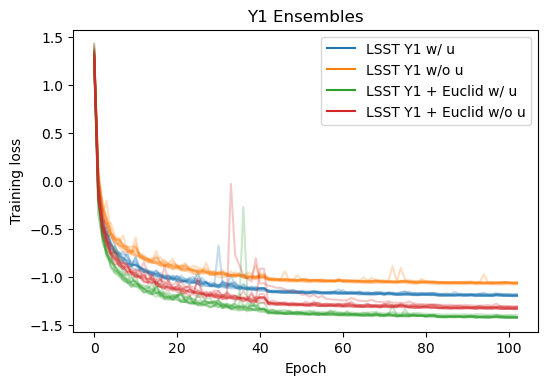

In [8]:
fig, ax = plt.subplots(dpi=100)

for i, name in enumerate(y1_ensembles):
    save_name = name.replace('+ ', '+').replace(' ', '_').replace('/', '')
    with open(f"saved-ensembles/losses/losses_for_{save_name}.pkl", "rb") as file:
        losses = pickle.load(file)["losses"]
    
    for loss in losses.values():
        ax.plot(loss, c=f"C{i}", alpha=0.25)
    ax.plot([], c=f"C{i}", label=name)
    
ax.legend()
ax.set(title="Y1 Ensembles", xlabel="Epoch", ylabel="Training loss")
plt.show()

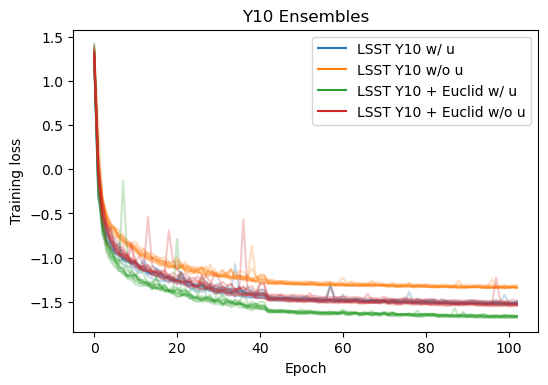

In [9]:
fig, ax = plt.subplots(dpi=100)

for i, name in enumerate(y10_ensembles):
    save_name = name.replace('+ ', '+').replace(' ', '_').replace('/', '')
    with open(f"saved-ensembles/losses/losses_for_{save_name}.pkl", "rb") as file:
        losses = pickle.load(file)["losses"]
    
    for loss in losses.values():
        ax.plot(loss, c=f"C{i}", alpha=0.25)
    ax.plot([], c=f"C{i}", label=name)
    
ax.legend()
ax.set(title="Y10 Ensembles", xlabel="Epoch", ylabel="Training loss")
plt.show()

We will aproximate the pdfs by drawing samples. I think this is a lot faster than calculating full pdfs, but I haven't tested this assumption.

In [55]:
Nsamples = 1000
y1_samples = {name: ens.sample(Nsamples, conditions=y1_test, seed=0) for name, ens in y1_ensembles.items()}
y10_samples = {name: ens.sample(Nsamples, conditions=y10_test, seed=0) for name, ens in y10_ensembles.items()}

Define a function that applies the redshift cuts and calculates the metrics.

In [50]:
# to calculate the size of these samples, 
# we need to get the full catalog, see how big
# the gold sample (i<25.3) is, and scale that number
# up to 4e9, per the SRD.
# This scaling will then be applied to the sample sizes
# to scale them from Melissa's catalog -> full LSST catalog
full_catalog = pd.read_csv(
    "catalogs/Euclid_trim_27p10_3p5_IR_4NUV.dat",
    delim_whitespace=True, comment='#', nrows=None, header=None,
    usecols=[i for i in range(1,11)],
    names=[
        "redshift", # truth
        "u", "g", "r", "i", "z", "y", # LSST
        "ey", "j", "h", # Euclid
    ]
)
catalog_scale = 4e9 / full_catalog[full_catalog["i"] < 25.3].shape[0]

# now we define a function to print the important metrics
def sample_metrics(
    samples: pd.DataFrame,    
    truth_test: pd.DataFrame,
    truth_full: pd.DataFrame,
    zmin: float = 2.3, # minimum redshift
    zmax: float = np.inf, # maximum redshift
    pcut: float = 0.95, # probability cut
    sort_column: str = "i"
):
    
    # sort the truth set
    truth_test_sorted = truth_test.sort_values(by=[sort_column])
    # sort the samples
    samples_sorted = samples.sort_values(by=[sort_column])
    
    # reshape so that each row corresponds to one glaxay in truth
    zsamples = samples_sorted.values[:, 0].reshape(truth_test.shape[0], -1)
    # get the probability that each galaxy passes the redshift cut
    prob_zcut = ((zsamples > zmin) & (zsamples < zmax)).mean(axis=1)
    # get the indices of the passing galaxies
    pass_true = np.where((truth_test_sorted["redshift"] > zmin) & (truth_test_sorted["redshift"] < zmax))[0]
    pass_pred = np.where(prob_zcut > pcut)[0]
    
    # compute the metrics
    passed = pass_pred.size / truth_test.shape[0]
    complete = np.isin(pass_true, pass_pred, assume_unique=True).mean()
    purity = np.isin(pass_pred, pass_true, assume_unique=True).mean()
    size = passed * truth_full.shape[0] * catalog_scale
    print(f"size = {size/1e6:>3.0f}M", end="     ")
    print(f"passed = {passed:.3f}", end="     ")
    print(f"completeness = {complete:.3f}", end="     ")
    print(f"purity = {purity:.3f}")

Calculate the metrics for the redshift > 2.3 cut:

In [53]:
print("cut redshift > 2.3")
for name, sample in y1_samples.items():
    print(f"{name:<25}", end=" ")
    sample_metrics(sample, y1_test, y1_catalog)
for name, sample in y10_samples.items():
    print(f"{name:<25}", end=" ")
    sample_metrics(sample, y10_test, y10_catalog)

cut redshift > 2.3
LSST Y1 w/ u              size =  18M     passed = 0.005     completeness = 0.123     purity = 0.990
LSST Y1 w/o u             size =  13M     passed = 0.004     completeness = 0.085     purity = 0.986
LSST Y1 + Euclid w/ u     size =  45M     passed = 0.013     completeness = 0.306     purity = 0.996
LSST Y1 + Euclid w/o u    size =  37M     passed = 0.011     completeness = 0.252     purity = 1.000
LSST Y10 w/ u             size = 214M     passed = 0.036     completeness = 0.490     purity = 0.993
LSST Y10 w/o u            size = 171M     passed = 0.029     completeness = 0.395     purity = 0.997
LSST Y10 + Euclid w/ u    size = 250M     passed = 0.042     completeness = 0.574     purity = 0.994
LSST Y10 + Euclid w/o u   size = 222M     passed = 0.037     completeness = 0.511     purity = 0.995


Calculate the metrics for the 1.5 < redshift < 2.3 cut:

In [54]:
print("cut 1.5 < redshift < 2.3")
for name, sample in y1_samples.items():
    print(f"{name:<25}", end=" ")
    sample_metrics(sample, y1_test, y1_catalog, zmin=1.5, zmax=2.3)
for name, sample in y10_samples.items():
    print(f"{name:<25}", end=" ")
    sample_metrics(sample, y10_test, y10_catalog, zmin=1.5, zmax=2.3)

cut 1.5 < redshift < 2.3
LSST Y1 w/ u              size = 178M     passed = 0.050     completeness = 0.239     purity = 0.986
LSST Y1 w/o u             size = 129M     passed = 0.036     completeness = 0.174     purity = 0.993
LSST Y1 + Euclid w/ u     size = 362M     passed = 0.102     completeness = 0.488     purity = 0.989
LSST Y1 + Euclid w/o u    size = 336M     passed = 0.095     completeness = 0.453     purity = 0.989
LSST Y10 w/ u             size = 660M     passed = 0.111     completeness = 0.437     purity = 0.994
LSST Y10 w/o u            size = 436M     passed = 0.073     completeness = 0.289     purity = 0.992
LSST Y10 + Euclid w/ u    size = 901M     passed = 0.151     completeness = 0.596     purity = 0.992
LSST Y10 + Euclid w/o u   size = 830M     passed = 0.139     completeness = 0.548     purity = 0.991
